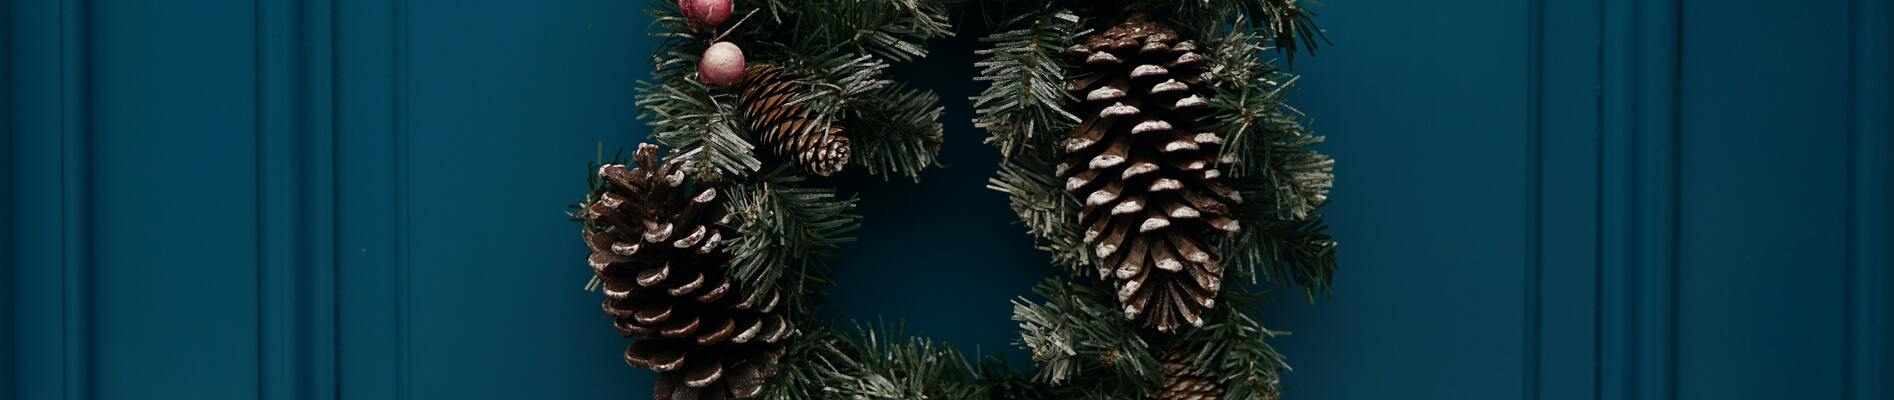

# Randomized Wildcard Postprocessing

This notebook is an attempt to perform clever wildcard postprocessing even starting from an optimal or nearly-optimal non-wildcard solution: feel free to copy it and try to see how much improvement you would have got!

Wildcards are made to shorten the transition costs and remove inefficiencies, but no evident ones are likely to appear in an optimal solution generated with a TSP solver: we have to voluntarily introduce them in the tours in a way that later allows us to get a benefit of 6 from each wildcard!

The idea is to first select where to place the two wildcards in a string, then modify the distance matrix so that two particular permutation sequences are very likely to appear in the tour, next perturb the optimal non-wildcard solution and finally reoptimize with a TSP solver given these new constraints. By randomizing the choice we have at the beginning and running the procedure dozens of times, we collect the rare results fruit of many trials and we are able to improve leaderboard from 2438 to 2430!

# Load Optimal Solution and Permutations Rebalancing

We load an optimal 2440 non-wildcard solution and helper functions from [Permutations Rebalancing](https://www.kaggle.com/kostyaatarik/permutations-rebalancing): kudos to the author, your notebooks were crazy good during this competition! 
We also prepare the input strings to feed to the [LKH-3](http://webhotel4.ruc.dk/~keld/research/LKH-3/) solver over and over again during all the steps of the procedure. These strings are immutable because we always want to start with the optimal solution before the random perturbation of the distance matrix, to revert back easily in case the optimization with the new constraints does not perform well.

In [ ]:
import itertools
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns


!wget http://webhotel4.ruc.dk/~keld/research/LKH-3/LKH-3.0.7.tgz &>/dev/null
!tar xvfz LKH-3.0.7.tgz &>/dev/null
!cd LKH-3.0.7; make &>/dev/null; cp LKH ..

In [ ]:
LETTERS = {
    1: '🎅',  # father christmas
    2: '🤶',  # mother christmas
    3: '🦌',  # reindeer
    4: '🧝',  # elf
    5: '🎄',  # christmas tree
    6: '🎁',  # gift
    7: '🎀',  # ribbon
    8: '🌟',  # star
}
INV_LETTERS = {v: k for k, v in LETTERS.items()}

LOAD_CSV = False

if LOAD_CSV:
    solution = pd.read_csv('../input/your_best_non-wildcard_solution.csv')
    strings = [[INV_LETTERS[c] for c in s] for s in solution.schedule]
else:
    # load best non-wildcard solution with lengths [2440, 2440, 2440]
    solution = ['🎅🤶🎄🎁🦌🎀🧝🤶🎅🎄🎁🦌🎀🧝🤶🎄🎅🎁🦌🎀🧝🤶🎄🎁🎅🦌🎀🧝🤶🎄🎁🦌🎅🎀🧝🤶🎄🎁🦌🎀🎅🧝🤶🎄🎁🦌🎀🎅🤶🎄🧝🎁🦌🎀🎅🤶🎄🧝🎀🎁🦌🤶🎅🎄🧝🎀🎁🦌🤶🎄🎅🧝🎀🎁🦌🤶🎄🧝🎅🎀🎁🦌🤶🎄🧝🎀🎅🎁🦌🤶🎄🧝🎀🎁🎅🦌🤶🎄🧝🎀🎁🎅🤶🦌🎄🧝🎁🎀🎅🤶🦌🎄🎁🎀🧝🎅🤶🦌🎁🎄🎀🧝🎅🤶🦌🎁🎀🧝🎄🎅🤶🦌🎁🎀🎄🧝🎅🤶🎁🦌🎄🎀🧝🎅🤶🎄🦌🎀🧝🎁🎅🤶🦌🎄🎀🎁🧝🎅🤶🦌🎀🎄🎁🧝🤶🎅🦌🎀🎄🎁🧝🤶🦌🎅🎀🎄🎁🧝🤶🦌🎀🎅🎄🎁🧝🤶🦌🎀🎄🎅🎁🧝🤶🦌🎀🎄🎁🎅🧝🤶🦌🎀🎄🎁🎅🤶🧝🦌🎀🎄🎁🎅🤶🧝🎀🦌🎄🎁🎅🤶🧝🎀🎄🦌🎁🎅🤶🎀🧝🎄🎁🦌🎅🤶🎀🧝🎄🦌🎁🎅🤶🎀🧝🦌🎁🎄🎅🤶🧝🎀🎁🎄🦌🤶🎅🧝🎀🎁🎄🦌🤶🧝🎅🎀🎁🎄🦌🤶🧝🎀🎅🎁🎄🦌🤶🧝🎀🎁🎅🎄🦌🤶🧝🎀🎁🎄🎅🦌🤶🧝🎀🎁🎄🎅🤶🦌🧝🎀🎁🎄🎅🤶🧝🦌🎄🎀🎁🤶🎅🧝🦌🎄🎀🎁🤶🧝🎅🦌🎄🎀🎁🤶🧝🦌🎅🎄🎀🎁🤶🧝🦌🎄🎅🎀🎁🤶🧝🦌🎄🎀🎅🎁🤶🧝🦌🎄🎀🎅🤶🎄🧝🦌🎀🎁🤶🎅🎄🧝🦌🎀🎁🤶🎄🎅🧝🦌🎀🎁🤶🎄🧝🎅🦌🎀🎁🤶🎄🧝🦌🎅🎀🎁🤶🎄🧝🦌🎀🎅🎁🤶🎄🧝🦌🎀🎅🤶🎁🎄🧝🦌🎀🎅🤶🎁🎄🦌🎀🧝🤶🎅🎁🎄🦌🎀🧝🤶🎁🎅🎄🦌🎀🧝🤶🎁🎄🎅🦌🎀🧝🤶🎁🎄🦌🎅🎀🧝🤶🎁🎄🦌🎀🎅🧝🤶🎁🎄🦌🎀🎅🤶🎁🎀🧝🎄🦌🎅🤶🎀🎁🦌🎄🧝🎅🤶🎀🦌🎄🧝🎁🎅🤶🎀🧝🎁🦌🎄🤶🎅🎀🧝🎁🦌🎄🤶🎀🎅🧝🎁🦌🎄🤶🎀🧝🎅🎁🦌🎄🤶🎀🧝🎁🎅🦌🎄🤶🎀🧝🎁🦌🎅🎄🤶🎀🧝🎁🦌🎅🤶🎄🎁🎀🦌🧝🤶🎅🎄🎁🎀🦌🧝🤶🎄🎅🎁🎀🦌🧝🤶🎄🎁🎅🎀🦌🧝🤶🎄🎁🎀🎅🦌🧝🤶🎄🎁🎀🦌🎅🧝🤶🎄🎁🎀🦌🎅🤶🧝🎄🎁🎀🦌🎅🤶🧝🎄🎁🦌🎀🤶🎅🧝🎄🎁🦌🎀🤶🧝🎅🎄🎁🦌🎀🤶🧝🎄🎅🎁🦌🎀🤶🧝🎄🎁🎅🦌🎀🤶🧝🎄🎁🦌🎅🎀🤶🧝🎄🎁🦌🎅🤶🧝🦌🎁🎄🎀🎅🤶🧝🎁🦌🎄🎀🎅🤶🎁🧝🦌🎄🎀🎅🤶🎁🦌🧝🎄🎀🤶🎅🎁🦌🧝🎄🎀🤶🎁🎅🦌🧝🎄🎀🤶🎁🦌🎅🧝🎄🎀🤶🎁🦌🧝🎅🎄🎀🤶🎁🦌🧝🎄🎅🎀🤶🎁🦌🧝🎄🎅🤶🎁🎀🎄🦌🧝🎅🤶🎀🎄🎁🦌🧝🎅🤶🎄🎁🧝🦌🎀🎅🤶🎄🦌🎀🎁🧝🎅🤶🎄🧝🎁🎀🦌🎅🤶🎄🎁🧝🎀🦌🤶🎅🎄🎁🧝🎀🦌🤶🎄🎅🎁🧝🎀🦌🤶🎄🎁🎅🧝🎀🦌🤶🎄🎁🧝🎅🎀🦌🤶🎄🎁🧝🎀🎅🦌🤶🎄🎁🧝🎀🎅🤶🎄🦌🎁🎀🧝🎅🤶🎄🎀🎁🦌🧝🤶🎅🎄🎀🎁🦌🧝🤶🎄🎅🎀🎁🦌🧝🤶🎄🎀🎅🎁🦌🧝🤶🎄🎀🎁🎅🦌🧝🤶🎄🎀🎁🦌🎅🧝🤶🎄🎀🎁🦌🎅🤶🧝🎄🎀🎁🦌🤶🎅🧝🎄🎀🎁🦌🤶🧝🎅🎄🎀🎁🦌🤶🧝🎄🎅🎀🎁🦌🤶🧝🎄🎀🎅🎁🦌🤶🧝🎄🎀🎁🎅🦌🤶🧝🎄🎀🎁🎅🤶🦌🧝🎀🎄🎁🎅🤶🎀🎄🦌🎁🧝🎅🤶🎀🎄🧝🎁🦌🎅🤶🎀🧝🎁🎄🦌🎅🤶🎀🎁🧝🦌🎄🎅🤶🎀🎁🎄🦌🧝🎅🤶🎁🦌🎀🎄🧝🎅🤶🎁🦌🎀🧝🎄🤶🎅🎁🦌🎀🧝🎄🤶🎁🎅🦌🎀🧝🎄🤶🎁🦌🎅🎀🧝🎄🤶🎁🦌🎀🎅🧝🎄🤶🎁🦌🎀🧝🎅🎄🤶🎁🦌🎀🧝🎅🤶🎁🎄🎀🦌🧝🎅🤶🎁🎄🧝🎀🦌🤶🎅🎁🎄🧝🎀🦌🤶🎁🎅🎄🧝🎀🦌🤶🎁🎄🎅🧝🎀🦌🤶🎁🎄🧝🎅🎀🦌🤶🎁🎄🧝🎀🎅🦌🤶🎁🎄🧝🎀🎅🤶🦌🧝🎄🎁🎀🤶🎅🦌🧝🎄🎁🎀🤶🦌🎅🧝🎄🎁🎀🤶🦌🧝🎅🎄🎁🎀🤶🦌🧝🎄🎅🎁🎀🤶🦌🧝🎄🎁🎅🎀🤶🦌🧝🎄🎁🎅🤶🦌🎀🧝🎄🎁🎅🤶🦌🎁🧝🎄🎀🤶🎅🦌🎁🧝🎄🎀🤶🦌🎅🎁🧝🎄🎀🤶🦌🎁🎅🧝🎄🎀🤶🦌🎁🧝🎅🎄🎀🤶🦌🎁🧝🎄🎅🎀🤶🦌🎁🧝🎄🎅🤶🎁🎀🦌🎄🧝🤶🎅🎁🎀🦌🎄🧝🤶🎁🎅🎀🦌🎄🧝🤶🎁🎀🎅🦌🎄🧝🤶🎁🎀🦌🎅🎄🧝🤶🎁🎀🦌🎄🎅🧝🤶🎁🎀🦌🎄🎅🤶🧝🎁🎀🦌🎄🎅🤶🧝🎀🎁🦌🎄🎅🤶🧝🎀🦌🎁🎄🎅🤶🧝🦌🎀🎁🎄🤶🎅🧝🦌🎀🎁🎄🤶🧝🎅🦌🎀🎁🎄🤶🧝🦌🎅🎀🎁🎄🤶🧝🦌🎀🎅🎁🎄🤶🧝🦌🎀🎁🎅🎄🤶🧝🦌🎀🎁🎅🤶🎀🦌🧝🎄🎁🤶🎅🎀🦌🧝🎄🎁🤶🎀🎅🦌🧝🎄🎁🤶🎀🦌🎅🧝🎄🎁🤶🎀🦌🧝🎅🎄🎁🤶🎀🦌🧝🎄🎅🎁🤶🎀🦌🧝🎄🎅🤶🎄🧝🦌🎁🎀🎅🤶🧝🎄🦌🎁🎀🎅🤶🧝🎄🎀🦌🎁🎅🤶🧝🎄🦌🎀🎁🎅🤶🦌🧝🎄🎀🎁🎅🤶🎄🎁🎀🧝🦌🎅🤶🎄🦌🧝🎀🎁🎅🤶🎄🎀🧝🦌🎁🤶🎅🎄🎀🧝🦌🎁🤶🎄🎅🎀🧝🦌🎁🤶🎄🎀🎅🧝🦌🎁🤶🎄🎀🧝🎅🦌🎁🤶🎄🎀🧝🦌🎅🎁🤶🎄🎀🧝🦌🎅🤶🦌🎁🎄🧝🎀🎅🤶🧝🎀🎄🎁🦌🎅🤶🎀🧝🦌🎄🎁🤶🎅🎀🧝🦌🎄🎁🤶🎀🎅🧝🦌🎄🎁🤶🎀🧝🎅🦌🎄🎁🤶🎀🧝🦌🎅🎄🎁🤶🎀🧝🦌🎄🎅🎁🤶🎀🧝🦌🎄🎅🤶🎀🎁🧝🎄🦌🤶🎅🎀🎁🧝🎄🦌🤶🎀🎅🎁🧝🎄🦌🤶🎀🎁🎅🧝🎄🦌🤶🎀🎁🧝🎅🎄🦌🤶🎀🎁🧝🎄🎅🦌🤶🎀🎁🧝🎄🎅🤶🎁🦌🧝🎀🎄🎅🤶🎁🧝🦌🎀🎄🎅🤶🧝🎁🦌🎀🎄🤶🎅🧝🎁🦌🎀🎄🤶🧝🎅🎁🦌🎀🎄🤶🧝🎁🎅🦌🎀🎄🤶🧝🎁🦌🎅🎀🎄🤶🧝🎁🦌🎀🎅🎄🤶🧝🎁🦌🎀🎅🤶🎄🧝🎀🦌🎁🎅🤶🎄🎁🦌🧝🎀🎅🤶🎄🦌🎁🧝🎀🤶🎅🎄🦌🎁🧝🎀🤶🎄🎅🦌🎁🧝🎀🤶🎄🦌🎅🎁🧝🎀🤶🎄🦌🎁🎅🧝🎀🤶🎄🦌🎁🧝🎅🎀🤶🎄🦌🎁🧝🎅🤶🎄🎀🦌🎁🧝🤶🎅🎄🎀🦌🎁🧝🤶🎄🎅🎀🦌🎁🧝🤶🎄🎀🎅🦌🎁🧝🤶🎄🎀🦌🎅🎁🧝🤶🎄🎀🦌🎁🎅🧝🤶🎄🎀🦌🎁🎅🤶🎄🎀🧝🎁🦌🎅🤶🎄🎀🦌🧝🎁🎅🤶🎀🦌🎄🎁🧝🎅🤶🎀🎄🧝🦌🎁🤶🎅🎀🎄🧝🦌🎁🤶🎀🎅🎄🧝🦌🎁🤶🎀🎄🎅🧝🦌🎁🤶🎀🎄🧝🎅🦌🎁🤶🎀🎄🧝🦌🎅🎁🤶🎀🎄🧝🦌🎅🤶🎁🎀🎄🧝🦌🎅🤶🎁🎄🦌🧝🎀🎅🤶🎁🧝🎄🦌🎀🎅🤶🎁🧝🎄🎀🦌🎅🤶🎁🧝🎀🦌🎄🎅🤶🎁🧝🎀🎄🦌🎅🤶🧝🎁🎄🎀🦌🎅🤶🧝🎁🎄🦌🎀🤶🎅🧝🎁🎄🦌🎀🤶🧝🎅🎁🎄🦌🎀🤶🧝🎁🎅🎄🦌🎀🤶🧝🎁🎄🎅🦌🎀🤶🧝🎁🎄🦌🎅🎀🤶🧝🎁🎄🦌🎅🤶🧝🎁🎀🎄🦌🤶🎅🧝🎁🎀🎄🦌🤶🧝🎅🎁🎀🎄🦌🤶🧝🎁🎅🎀🎄🦌🤶🧝🎁🎀🎅🎄🦌🤶🧝🎁🎀🎄🎅🦌🤶🧝🎁🎀🎄🎅🤶🦌🧝🎁🎄🎀🎅🤶🧝🦌🎁🎀🎄🎅🤶🦌🎁🧝🎀🎄🎅🤶🦌🧝🎁🎀🎄🤶🎅🦌🧝🎁🎀🎄🤶🦌🎅🧝🎁🎀🎄🤶🦌🧝🎅🎁🎀🎄🤶🦌🧝🎁🎅🎀🎄🤶🦌🧝🎁🎀🎅🎄🤶🦌🧝🎁🎀🎅🤶🎄🦌🧝🎁🎀🤶🎅🎄🦌🧝🎁🎀🤶🎄🎅🦌🧝🎁🎀🤶🎄🦌🎅🧝🎁🎀🤶🎄🦌🧝🎅🎁🎀🤶🎄🦌🧝🎁🎅🎀🤶🎄🦌🧝🎁🎅🤶🎀🎄🦌🧝🎁🤶🎅🎀🎄🦌🧝🎁🤶🎀🎅🎄🦌🧝🎁🤶🎀🎄🎅🦌🧝🎁🤶🎀🎄🦌🎅🧝🎁🤶🎀🎄🦌🧝🎅🎁🤶🎀🎄🦌🧝🎅🤶🎁🎄🎀🧝🦌🎅🤶🎁🎀🦌🧝🎄🎅🤶🎁🎀🧝🦌🎄🤶🎅🎁🎀🧝🦌🎄🤶🎁🎅🎀🧝🦌🎄🤶🎁🎀🎅🧝🦌🎄🤶🎁🎀🧝🎅🦌🎄🤶🎁🎀🧝🦌🎅🎄🤶🎁🎀🧝🦌🎅🤶🎀🎁🎄🧝🦌🤶🎅🎀🎁🎄🧝🦌🤶🎀🎅🎁🎄🧝🦌🤶🎀🎁🎅🎄🧝🦌🤶🎀🎁🎄🎅🧝🦌🤶🎀🎁🎄🧝🎅🦌🤶🎀🎁🎄🧝🎅🤶🦌🎀🎁🧝🎄🎅🤶🦌🎀🎁🎄🧝🎅🤶🎀🦌🎁🧝🎄🎅🤶🎀🎁🦌🧝🎄🤶🎅🎀🎁🦌🧝🎄🤶🎀🎅🎁🦌🧝🎄🤶🎀🎁🎅🦌🧝🎄🤶🎀🎁🦌🎅🧝🎄🤶🎀🎁🦌🧝🎅🎄🤶🎀🎁🦌🧝🎅🤶🎄🎀🎁🧝🦌🎅🤶🎀🎄🎁🧝🦌🤶🎅🎀🎄🎁🧝🦌🤶🎀🎅🎄🎁🧝🦌🤶🎀🎄🎅🎁🧝🦌🤶🎀🎄🎁🎅🧝🦌🤶🎀🎄🎁🧝🎅🦌🤶🎀🎄🎁🧝🎅🤶🦌🎀🧝🎁🎄🎅🤶🧝🦌🎄🎁🎀🎅🤶🦌🎄🧝🎀🎁🎅🤶🦌🎀🎄🧝🎁🎅🤶🎀🦌🧝🎁🎄🎅🤶🦌🎄🎀🧝🎁🤶🎅🦌🎄🎀🧝🎁🤶🦌🎅🎄🎀🧝🎁🤶🦌🎄🎅🎀🧝🎁🤶🦌🎄🎀🎅🧝🎁🤶🦌🎄🎀🧝🎅🎁🤶🦌🎄🎀🧝🎅🤶🎁🦌🎄🧝🎀🎅🤶🦌🎄🎁🧝🎀🤶🎅🦌🎄🎁🧝🎀🤶🦌🎅🎄🎁🧝🎀🤶🦌🎄🎅🎁🧝🎀🤶🦌🎄🎁🎅🧝🎀🤶🦌🎄🎁🧝🎅🎀🤶🦌🎄🎁🧝🎅🤶🎀🦌🎁🎄🧝🤶🎅🎀🦌🎁🎄🧝🤶🎀🎅🦌🎁🎄🧝🤶🎀🦌🎅🎁🎄🧝🤶🎀🦌🎁🎅🎄🧝🤶🎀🦌🎁🎄🎅🧝🤶🎀🦌🎁🎄',
                '🎅🤶🦌🧝🎀🎄🎁🤶🎅🦌🧝🎀🎄🎁🤶🦌🎅🧝🎀🎄🎁🤶🦌🧝🎅🎀🎄🎁🤶🦌🧝🎀🎅🎄🎁🤶🦌🧝🎀🎄🎅🎁🤶🦌🧝🎀🎄🎅🤶🎀🦌🧝🎁🎄🎅🤶🦌🎀🧝🎁🎄🤶🎅🦌🎀🧝🎁🎄🤶🦌🎅🎀🧝🎁🎄🤶🦌🎀🎅🧝🎁🎄🤶🦌🎀🧝🎅🎁🎄🤶🦌🎀🧝🎁🎅🎄🤶🦌🎀🧝🎁🎅🤶🎄🦌🎁🎀🧝🎅🤶🎁🎄🦌🎀🧝🎅🤶🦌🎀🎄🎁🧝🎅🤶🎀🎄🦌🧝🎁🎅🤶🎄🦌🎀🧝🎁🎅🤶🎄🎀🦌🧝🎁🤶🎅🎄🎀🦌🧝🎁🤶🎄🎅🎀🦌🧝🎁🤶🎄🎀🎅🦌🧝🎁🤶🎄🎀🦌🎅🧝🎁🤶🎄🎀🦌🧝🎅🎁🤶🎄🎀🦌🧝🎅🤶🎄🎁🎀🧝🦌🎅🤶🎁🎄🎀🦌🧝🎅🤶🎄🎁🎀🦌🧝🎅🤶🦌🎁🎄🎀🧝🤶🎅🦌🎁🎄🎀🧝🤶🦌🎅🎁🎄🎀🧝🤶🦌🎁🎅🎄🎀🧝🤶🦌🎁🎄🎅🎀🧝🤶🦌🎁🎄🎀🎅🧝🤶🦌🎁🎄🎀🎅🤶🎁🎀🎄🦌🧝🎅🤶🎁🎀🧝🎄🦌🎅🤶🎁🧝🎀🎄🦌🤶🎅🎁🧝🎀🎄🦌🤶🎁🎅🧝🎀🎄🦌🤶🎁🧝🎅🎀🎄🦌🤶🎁🧝🎀🎅🎄🦌🤶🎁🧝🎀🎄🎅🦌🤶🎁🧝🎀🎄🎅🤶🎁🦌🎀🎄🧝🎅🤶🎀🦌🎁🎄🧝🎅🤶🎀🎄🦌🎁🧝🎅🤶🎀🎄🎁🧝🦌🎅🤶🎀🎄🧝🎁🦌🎅🤶🎄🎀🎁🧝🦌🎅🤶🎄🎁🦌🧝🎀🤶🎅🎄🎁🦌🧝🎀🤶🎄🎅🎁🦌🧝🎀🤶🎄🎁🎅🦌🧝🎀🤶🎄🎁🦌🎅🧝🎀🤶🎄🎁🦌🧝🎅🎀🤶🎄🎁🦌🧝🎅🤶🎁🎄🧝🦌🎀🤶🎅🎁🎄🧝🦌🎀🤶🎁🎅🎄🧝🦌🎀🤶🎁🎄🎅🧝🦌🎀🤶🎁🎄🧝🎅🦌🎀🤶🎁🎄🧝🦌🎅🎀🤶🎁🎄🧝🦌🎅🤶🎀🎁🧝🎄🦌🎅🤶🧝🎁🎀🦌🎄🤶🎅🧝🎁🎀🦌🎄🤶🧝🎅🎁🎀🦌🎄🤶🧝🎁🎅🎀🦌🎄🤶🧝🎁🎀🎅🦌🎄🤶🧝🎁🎀🦌🎅🎄🤶🧝🎁🎀🦌🎅🤶🎄🧝🎁🎀🦌🤶🎅🎄🧝🎁🎀🦌🤶🎄🎅🧝🎁🎀🦌🤶🎄🧝🎅🎁🎀🦌🤶🎄🧝🎁🎅🎀🦌🤶🎄🧝🎁🎀🎅🦌🤶🎄🧝🎁🎀🎅🤶🧝🦌🎄🎁🎀🤶🎅🧝🦌🎄🎁🎀🤶🧝🎅🦌🎄🎁🎀🤶🧝🦌🎅🎄🎁🎀🤶🧝🦌🎄🎅🎁🎀🤶🧝🦌🎄🎁🎅🎀🤶🧝🦌🎄🎁🎅🤶🎀🧝🎁🎄🦌🎅🤶🎁🎀🎄🧝🦌🤶🎅🎁🎀🎄🧝🦌🤶🎁🎅🎀🎄🧝🦌🤶🎁🎀🎅🎄🧝🦌🤶🎁🎀🎄🎅🧝🦌🤶🎁🎀🎄🧝🎅🦌🤶🎁🎀🎄🧝🎅🤶🦌🎁🎀🧝🎄🎅🤶🎁🦌🎄🎀🧝🤶🎅🎁🦌🎄🎀🧝🤶🎁🎅🦌🎄🎀🧝🤶🎁🦌🎅🎄🎀🧝🤶🎁🦌🎄🎅🎀🧝🤶🎁🦌🎄🎀🎅🧝🤶🎁🦌🎄🎀🎅🤶🧝🎁🦌🎀🎄🎅🤶🎁🧝🎀🦌🎄🎅🤶🎁🎀🧝🦌🎄🎅🤶🎁🎀🦌🧝🎄🤶🎅🎁🎀🦌🧝🎄🤶🎁🎅🎀🦌🧝🎄🤶🎁🎀🎅🦌🧝🎄🤶🎁🎀🦌🎅🧝🎄🤶🎁🎀🦌🧝🎅🎄🤶🎁🎀🦌🧝🎅🤶🎄🧝🦌🎀🎁🎅🤶🧝🎄🦌🎁🎀🎅🤶🦌🧝🎁🎀🎄🎅🤶🎁🦌🧝🎄🎀🎅🤶🦌🎄🧝🎁🎀🎅🤶🎄🦌🧝🎀🎁🎅🤶🎄🎀🧝🎁🦌🎅🤶🎄🎀🧝🦌🎁🎅🤶🎄🎀🎁🦌🧝🎅🤶🎀🎁🎄🦌🧝🤶🎅🎀🎁🎄🦌🧝🤶🎀🎅🎁🎄🦌🧝🤶🎀🎁🎅🎄🦌🧝🤶🎀🎁🎄🎅🦌🧝🤶🎀🎁🎄🦌🎅🧝🤶🎀🎁🎄🦌🎅🤶🧝🎀🎁🦌🎄🎅🤶🧝🦌🎀🎄🎁🤶🎅🧝🦌🎀🎄🎁🤶🧝🎅🦌🎀🎄🎁🤶🧝🦌🎅🎀🎄🎁🤶🧝🦌🎀🎅🎄🎁🤶🧝🦌🎀🎄🎅🎁🤶🧝🦌🎀🎄🎅🤶🧝🦌🎁🎀🎄🤶🎅🧝🦌🎁🎀🎄🤶🧝🎅🦌🎁🎀🎄🤶🧝🦌🎅🎁🎀🎄🤶🧝🦌🎁🎅🎀🎄🤶🧝🦌🎁🎀🎅🎄🤶🧝🦌🎁🎀🎅🤶🎀🦌🎁🧝🎄🤶🎅🎀🦌🎁🧝🎄🤶🎀🎅🦌🎁🧝🎄🤶🎀🦌🎅🎁🧝🎄🤶🎀🦌🎁🎅🧝🎄🤶🎀🦌🎁🧝🎅🎄🤶🎀🦌🎁🧝🎅🤶🎀🎄🎁🦌🧝🤶🎅🎀🎄🎁🦌🧝🤶🎀🎅🎄🎁🦌🧝🤶🎀🎄🎅🎁🦌🧝🤶🎀🎄🎁🎅🦌🧝🤶🎀🎄🎁🦌🎅🧝🤶🎀🎄🎁🦌🎅🤶🧝🎀🎄🎁🦌🤶🎅🧝🎀🎄🎁🦌🤶🧝🎅🎀🎄🎁🦌🤶🧝🎀🎅🎄🎁🦌🤶🧝🎀🎄🎅🎁🦌🤶🧝🎀🎄🎁🎅🦌🤶🧝🎀🎄🎁🎅🤶🦌🧝🎀🎁🎄🤶🎅🦌🧝🎀🎁🎄🤶🦌🎅🧝🎀🎁🎄🤶🦌🧝🎅🎀🎁🎄🤶🦌🧝🎀🎅🎁🎄🤶🦌🧝🎀🎁🎅🎄🤶🦌🧝🎀🎁🎅🤶🦌🎄🎀🧝🎁🎅🤶🦌🎄🧝🎀🎁🤶🎅🦌🎄🧝🎀🎁🤶🦌🎅🎄🧝🎀🎁🤶🦌🎄🎅🧝🎀🎁🤶🦌🎄🧝🎅🎀🎁🤶🦌🎄🧝🎀🎅🎁🤶🦌🎄🧝🎀🎅🤶🦌🎁🎄🧝🎀🎅🤶🦌🧝🎄🎁🎀🎅🤶🧝🎄🎀🎁🦌🎅🤶🎄🧝🎀🎁🦌🎅🤶🎄🧝🎁🦌🎀🎅🤶🧝🎄🦌🎀🎁🤶🎅🧝🎄🦌🎀🎁🤶🧝🎅🎄🦌🎀🎁🤶🧝🎄🎅🦌🎀🎁🤶🧝🎄🦌🎅🎀🎁🤶🧝🎄🦌🎀🎅🎁🤶🧝🎄🦌🎀🎅🤶🧝🎁🦌🎄🎀🤶🎅🧝🎁🦌🎄🎀🤶🧝🎅🎁🦌🎄🎀🤶🧝🎁🎅🦌🎄🎀🤶🧝🎁🦌🎅🎄🎀🤶🧝🎁🦌🎄🎅🎀🤶🧝🎁🦌🎄🎅🤶🎀🧝🎁🦌🎄🎅🤶🎀🎁🦌🧝🎄🎅🤶🎀🎁🧝🦌🎄🤶🎅🎀🎁🧝🦌🎄🤶🎀🎅🎁🧝🦌🎄🤶🎀🎁🎅🧝🦌🎄🤶🎀🎁🧝🎅🦌🎄🤶🎀🎁🧝🦌🎅🎄🤶🎀🎁🧝🦌🎅🤶🎀🎁🎄🧝🦌🎅🤶🎁🎄🎀🧝🦌🤶🎅🎁🎄🎀🧝🦌🤶🎁🎅🎄🎀🧝🦌🤶🎁🎄🎅🎀🧝🦌🤶🎁🎄🎀🎅🧝🦌🤶🎁🎄🎀🧝🎅🦌🤶🎁🎄🎀🧝🎅🤶🎄🧝🦌🎁🎀🤶🎅🎄🧝🦌🎁🎀🤶🎄🎅🧝🦌🎁🎀🤶🎄🧝🎅🦌🎁🎀🤶🎄🧝🦌🎅🎁🎀🤶🎄🧝🦌🎁🎅🎀🤶🎄🧝🦌🎁🎅🤶🎀🎁🦌🎄🧝🎅🤶🎄🎁🧝🦌🎀🤶🎅🎄🎁🧝🦌🎀🤶🎄🎅🎁🧝🦌🎀🤶🎄🎁🎅🧝🦌🎀🤶🎄🎁🧝🎅🦌🎀🤶🎄🎁🧝🦌🎅🎀🤶🎄🎁🧝🦌🎅🤶🦌🎀🎁🧝🎄🎅🤶🎁🦌🎀🧝🎄🎅🤶🧝🎀🦌🎁🎄🤶🎅🧝🎀🦌🎁🎄🤶🧝🎅🎀🦌🎁🎄🤶🧝🎀🎅🦌🎁🎄🤶🧝🎀🦌🎅🎁🎄🤶🧝🎀🦌🎁🎅🎄🤶🧝🎀🦌🎁🎅🤶🎄🧝🎀🦌🎁🤶🎅🎄🧝🎀🦌🎁🤶🎄🎅🧝🎀🦌🎁🤶🎄🧝🎅🎀🦌🎁🤶🎄🧝🎀🎅🦌🎁🤶🎄🧝🎀🦌🎅🎁🤶🎄🧝🎀🦌🎅🤶🦌🎁🧝🎀🎄🤶🎅🦌🎁🧝🎀🎄🤶🦌🎅🎁🧝🎀🎄🤶🦌🎁🎅🧝🎀🎄🤶🦌🎁🧝🎅🎀🎄🤶🦌🎁🧝🎀🎅🎄🤶🦌🎁🧝🎀🎅🤶🎁🦌🎄🧝🎀🎅🤶🎁🦌🧝🎀🎄🎅🤶🧝🦌🎁🎄🎀🎅🤶🎁🎀🦌🎄🧝🎅🤶🦌🎁🎀🎄🧝🤶🎅🦌🎁🎀🎄🧝🤶🦌🎅🎁🎀🎄🧝🤶🦌🎁🎅🎀🎄🧝🤶🦌🎁🎀🎅🎄🧝🤶🦌🎁🎀🎄🎅🧝🤶🦌🎁🎀🎄🎅🤶🧝🦌🎀🎁🎄🎅🤶🧝🎀🦌🎄🎁🎅🤶🎀🦌🎄🧝🎁🎅🤶🎁🧝🦌🎀🎄🤶🎅🎁🧝🦌🎀🎄🤶🎁🎅🧝🦌🎀🎄🤶🎁🧝🎅🦌🎀🎄🤶🎁🧝🦌🎅🎀🎄🤶🎁🧝🦌🎀🎅🎄🤶🎁🧝🦌🎀🎅🤶🎄🎁🦌🎀🧝🎅🤶🦌🎀🎁🎄🧝🎅🤶🦌🎀🎄🧝🎁🤶🎅🦌🎀🎄🧝🎁🤶🦌🎅🎀🎄🧝🎁🤶🦌🎀🎅🎄🧝🎁🤶🦌🎀🎄🎅🧝🎁🤶🦌🎀🎄🧝🎅🎁🤶🦌🎀🎄🧝🎅🤶🧝🎁🎄🦌🎀🎅🤶🧝🎄🎁🎀🦌🎅🤶🎁🎄🧝🎀🦌🎅🤶🎁🎄🦌🧝🎀🤶🎅🎁🎄🦌🧝🎀🤶🎁🎅🎄🦌🧝🎀🤶🎁🎄🎅🦌🧝🎀🤶🎁🎄🦌🎅🧝🎀🤶🎁🎄🦌🧝🎅🎀🤶🎁🎄🦌🧝🎅🤶🦌🧝🎄🎀🎁🎅🤶🧝🦌🎄🎀🎁🎅🤶🎄🎁🧝🎀🦌🎅🤶🦌🎄🎀🎁🧝🎅🤶🎄🦌🧝🎁🎀🎅🤶🦌🎁🧝🎄🎀🎅🤶🎁🧝🦌🎄🎀🎅🤶🧝🎄🎁🦌🎀🎅🤶🧝🎁🎀🎄🦌🎅🤶🧝🎀🎁🎄🦌🎅🤶🧝🎀🎄🦌🎁🎅🤶🦌🎀🧝🎄🎁🎅🤶🎀🦌🧝🎄🎁🎅🤶🎀🦌🎄🎁🧝🤶🎅🎀🦌🎄🎁🧝🤶🎀🎅🦌🎄🎁🧝🤶🎀🦌🎅🎄🎁🧝🤶🎀🦌🎄🎅🎁🧝🤶🎀🦌🎄🎁🎅🧝🤶🎀🦌🎄🎁🎅🤶🎀🧝🦌🎄🎁🎅🤶🎀🎄🧝🦌🎁🎅🤶🎀🧝🎄🦌🎁🎅🤶🦌🧝🎁🎄🎀🤶🎅🦌🧝🎁🎄🎀🤶🦌🎅🧝🎁🎄🎀🤶🦌🧝🎅🎁🎄🎀🤶🦌🧝🎁🎅🎄🎀🤶🦌🧝🎁🎄🎅🎀🤶🦌🧝🎁🎄🎅🤶🎀🧝🦌🎁🎄🎅🤶🎀🧝🎄🎁🦌🤶🎅🎀🧝🎄🎁🦌🤶🎀🎅🧝🎄🎁🦌🤶🎀🧝🎅🎄🎁🦌🤶🎀🧝🎄🎅🎁🦌🤶🎀🧝🎄🎁🎅🦌🤶🎀🧝🎄🎁🎅🤶🦌🎄🎁🧝🎀🎅🤶🦌🎄🎁🎀🧝🎅🤶🎄🦌🎁🧝🎀🎅🤶🎄🎀🦌🎁🧝🎅🤶🎄🦌🎀🎁🧝🤶🎅🎄🦌🎀🎁🧝🤶🎄🎅🦌🎀🎁🧝🤶🎄🦌🎅🎀🎁🧝🤶🎄🦌🎀🎅🎁🧝🤶🎄🦌🎀🎁🎅🧝🤶🎄🦌🎀🎁🎅🤶🧝🎄🎀🦌🎁🤶🎅🧝🎄🎀🦌🎁🤶🧝🎅🎄🎀🦌🎁🤶🧝🎄🎅🎀🦌🎁🤶🧝🎄🎀🎅🦌🎁🤶🧝🎄🎀🦌🎅🎁🤶🧝🎄🎀🦌🎅🤶🎁🧝🎄🦌🎀🎅🤶🧝🎁🎄🎀🦌🎅🤶🎁🧝🎄🎀🦌🤶🎅🎁🧝🎄🎀🦌🤶🎁🎅🧝🎄🎀🦌🤶🎁🧝🎅🎄🎀🦌🤶🎁🧝🎄🎅🎀🦌🤶🎁🧝🎄🎀🎅🦌🤶🎁🧝🎄🎀',
                '🎅🤶🦌🧝🎄🎁🎀🎅🤶🦌🧝🎄🎀🎁🤶🎅🦌🧝🎄🎀🎁🤶🦌🎅🧝🎄🎀🎁🤶🦌🧝🎅🎄🎀🎁🤶🦌🧝🎄🎅🎀🎁🤶🦌🧝🎄🎀🎅🎁🤶🦌🧝🎄🎀🎅🤶🎁🦌🎄🧝🎀🤶🎅🎁🦌🎄🧝🎀🤶🎁🎅🦌🎄🧝🎀🤶🎁🦌🎅🎄🧝🎀🤶🎁🦌🎄🎅🧝🎀🤶🎁🦌🎄🧝🎅🎀🤶🎁🦌🎄🧝🎅🤶🎁🎀🎄🧝🦌🎅🤶🎄🎀🦌🎁🧝🎅🤶🎀🦌🎄🎁🧝🎅🤶🦌🎄🎀🎁🧝🤶🎅🦌🎄🎀🎁🧝🤶🦌🎅🎄🎀🎁🧝🤶🦌🎄🎅🎀🎁🧝🤶🦌🎄🎀🎅🎁🧝🤶🦌🎄🎀🎁🎅🧝🤶🦌🎄🎀🎁🎅🤶🧝🦌🎁🎀🎄🎅🤶🧝🎁🦌🎄🎀🎅🤶🧝🎁🎄🦌🎀🎅🤶🧝🦌🎁🎄🎀🤶🎅🧝🦌🎁🎄🎀🤶🧝🎅🦌🎁🎄🎀🤶🧝🦌🎅🎁🎄🎀🤶🧝🦌🎁🎅🎄🎀🤶🧝🦌🎁🎄🎅🎀🤶🧝🦌🎁🎄🎅🤶🧝🎁🎀🦌🎄🎅🤶🧝🎁🎀🎄🦌🎅🤶🎀🧝🎁🦌🎄🎅🤶🎀🧝🦌🎄🎁🎅🤶🎄🦌🧝🎀🎁🤶🎅🎄🦌🧝🎀🎁🤶🎄🎅🦌🧝🎀🎁🤶🎄🦌🎅🧝🎀🎁🤶🎄🦌🧝🎅🎀🎁🤶🎄🦌🧝🎀🎅🎁🤶🎄🦌🧝🎀🎅🤶🎄🎁🦌🧝🎀🎅🤶🎁🎄🦌🧝🎀🎅🤶🎁🧝🎄🦌🎀🤶🎅🎁🧝🎄🦌🎀🤶🎁🎅🧝🎄🦌🎀🤶🎁🧝🎅🎄🦌🎀🤶🎁🧝🎄🎅🦌🎀🤶🎁🧝🎄🦌🎅🎀🤶🎁🧝🎄🦌🎅🤶🎄🎀🧝🎁🦌🤶🎅🎄🎀🧝🎁🦌🤶🎄🎅🎀🧝🎁🦌🤶🎄🎀🎅🧝🎁🦌🤶🎄🎀🧝🎅🎁🦌🤶🎄🎀🧝🎁🎅🦌🤶🎄🎀🧝🎁🎅🤶🎁🦌🎀🧝🎄🎅🤶🎁🦌🧝🎀🎄🤶🎅🎁🦌🧝🎀🎄🤶🎁🎅🦌🧝🎀🎄🤶🎁🦌🎅🧝🎀🎄🤶🎁🦌🧝🎅🎀🎄🤶🎁🦌🧝🎀🎅🎄🤶🎁🦌🧝🎀🎅🤶🎀🎁🎄🦌🧝🎅🤶🎀🎁🧝🦌🎄🎅🤶🧝🎀🦌🎄🎁🤶🎅🧝🎀🦌🎄🎁🤶🧝🎅🎀🦌🎄🎁🤶🧝🎀🎅🦌🎄🎁🤶🧝🎀🦌🎅🎄🎁🤶🧝🎀🦌🎄🎅🎁🤶🧝🎀🦌🎄🎅🤶🦌🎀🎄🎁🧝🎅🤶🧝🎀🦌🎁🎄🎅🤶🧝🦌🎀🎁🎄🎅🤶🧝🎄🦌🎀🎁🎅🤶🎄🧝🎀🎁🦌🎅🤶🎀🧝🦌🎁🎄🤶🎅🎀🧝🦌🎁🎄🤶🎀🎅🧝🦌🎁🎄🤶🎀🧝🎅🦌🎁🎄🤶🎀🧝🦌🎅🎁🎄🤶🎀🧝🦌🎁🎅🎄🤶🎀🧝🦌🎁🎅🤶🎀🧝🎄🦌🎁🤶🎅🎀🧝🎄🦌🎁🤶🎀🎅🧝🎄🦌🎁🤶🎀🧝🎅🎄🦌🎁🤶🎀🧝🎄🎅🦌🎁🤶🎀🧝🎄🦌🎅🎁🤶🎀🧝🎄🦌🎅🤶🎁🎀🧝🎄🦌🤶🎅🎁🎀🧝🎄🦌🤶🎁🎅🎀🧝🎄🦌🤶🎁🎀🎅🧝🎄🦌🤶🎁🎀🧝🎅🎄🦌🤶🎁🎀🧝🎄🎅🦌🤶🎁🎀🧝🎄🎅🤶🎁🦌🎀🎄🧝🤶🎅🎁🦌🎀🎄🧝🤶🎁🎅🦌🎀🎄🧝🤶🎁🦌🎅🎀🎄🧝🤶🎁🦌🎀🎅🎄🧝🤶🎁🦌🎀🎄🎅🧝🤶🎁🦌🎀🎄🎅🤶🧝🎁🦌🎀🎄🎅🤶🧝🎄🎀🦌🎁🎅🤶🧝🎄🦌🎁🎀🤶🎅🧝🎄🦌🎁🎀🤶🧝🎅🎄🦌🎁🎀🤶🧝🎄🎅🦌🎁🎀🤶🧝🎄🦌🎅🎁🎀🤶🧝🎄🦌🎁🎅🎀🤶🧝🎄🦌🎁🎅🤶🧝🎀🎁🦌🎄🤶🎅🧝🎀🎁🦌🎄🤶🧝🎅🎀🎁🦌🎄🤶🧝🎀🎅🎁🦌🎄🤶🧝🎀🎁🎅🦌🎄🤶🧝🎀🎁🦌🎅🎄🤶🧝🎀🎁🦌🎅🤶🦌🎄🧝🎁🎀🤶🎅🦌🎄🧝🎁🎀🤶🦌🎅🎄🧝🎁🎀🤶🦌🎄🎅🧝🎁🎀🤶🦌🎄🧝🎅🎁🎀🤶🦌🎄🧝🎁🎅🎀🤶🦌🎄🧝🎁🎅🤶🎄🦌🎀🎁🧝🎅🤶🎄🦌🎁🧝🎀🎅🤶🦌🎁🎄🧝🎀🤶🎅🦌🎁🎄🧝🎀🤶🦌🎅🎁🎄🧝🎀🤶🦌🎁🎅🎄🧝🎀🤶🦌🎁🎄🎅🧝🎀🤶🦌🎁🎄🧝🎅🎀🤶🦌🎁🎄🧝🎅🤶🎀🎁🦌🎄🧝🤶🎅🎀🎁🦌🎄🧝🤶🎀🎅🎁🦌🎄🧝🤶🎀🎁🎅🦌🎄🧝🤶🎀🎁🦌🎅🎄🧝🤶🎀🎁🦌🎄🎅🧝🤶🎀🎁🦌🎄🎅🤶🎁🧝🎀🦌🎄🤶🎅🎁🧝🎀🦌🎄🤶🎁🎅🧝🎀🦌🎄🤶🎁🧝🎅🎀🦌🎄🤶🎁🧝🎀🎅🦌🎄🤶🎁🧝🎀🦌🎅🎄🤶🎁🧝🎀🦌🎅🤶🎁🦌🎄🎀🧝🎅🤶🎄🦌🎁🎀🧝🤶🎅🎄🦌🎁🎀🧝🤶🎄🎅🦌🎁🎀🧝🤶🎄🦌🎅🎁🎀🧝🤶🎄🦌🎁🎅🎀🧝🤶🎄🦌🎁🎀🎅🧝🤶🎄🦌🎁🎀🎅🤶🎄🧝🎁🦌🎀🤶🎅🎄🧝🎁🦌🎀🤶🎄🎅🧝🎁🦌🎀🤶🎄🧝🎅🎁🦌🎀🤶🎄🧝🎁🎅🦌🎀🤶🎄🧝🎁🦌🎅🎀🤶🎄🧝🎁🦌🎅🤶🎀🎄🦌🧝🎁🎅🤶🎄🎀🧝🦌🎁🎅🤶🎀🎄🧝🦌🎁🎅🤶🎀🎄🎁🧝🦌🎅🤶🎄🎀🎁🦌🧝🎅🤶🎀🎁🎄🧝🦌🎅🤶🎁🎄🎀🧝🦌🎅🤶🎄🎁🎀🧝🦌🤶🎅🎄🎁🎀🧝🦌🤶🎄🎅🎁🎀🧝🦌🤶🎄🎁🎅🎀🧝🦌🤶🎄🎁🎀🎅🧝🦌🤶🎄🎁🎀🧝🎅🦌🤶🎄🎁🎀🧝🎅🤶🦌🎄🎁🎀🧝🤶🎅🦌🎄🎁🎀🧝🤶🦌🎅🎄🎁🎀🧝🤶🦌🎄🎅🎁🎀🧝🤶🦌🎄🎁🎅🎀🧝🤶🦌🎄🎁🎀🎅🧝🤶🦌🎄🎁🎀🎅🤶🧝🦌🎄🎀🎁🎅🤶🎄🧝🦌🎀🎁🎅🤶🎄🎀🦌🧝🎁🎅🤶🦌🎀🎄🧝🎁🎅🤶🦌🎀🎁🎄🧝🤶🎅🦌🎀🎁🎄🧝🤶🦌🎅🎀🎁🎄🧝🤶🦌🎀🎅🎁🎄🧝🤶🦌🎀🎁🎅🎄🧝🤶🦌🎀🎁🎄🎅🧝🤶🦌🎀🎁🎄🎅🤶🧝🎀🎁🎄🦌🎅🤶🎀🧝🎁🎄🦌🤶🎅🎀🧝🎁🎄🦌🤶🎀🎅🧝🎁🎄🦌🤶🎀🧝🎅🎁🎄🦌🤶🎀🧝🎁🎅🎄🦌🤶🎀🧝🎁🎄🎅🦌🤶🎀🧝🎁🎄🎅🤶🦌🎀🧝🎄🎁🤶🎅🦌🎀🧝🎄🎁🤶🦌🎅🎀🧝🎄🎁🤶🦌🎀🎅🧝🎄🎁🤶🦌🎀🧝🎅🎄🎁🤶🦌🎀🧝🎄🎅🎁🤶🦌🎀🧝🎄🎅🤶🎀🦌🎁🎄🧝🎅🤶🦌🧝🎁🎀🎄🎅🤶🦌🎁🎀🧝🎄🤶🎅🦌🎁🎀🧝🎄🤶🦌🎅🎁🎀🧝🎄🤶🦌🎁🎅🎀🧝🎄🤶🦌🎁🎀🎅🧝🎄🤶🦌🎁🎀🧝🎅🎄🤶🦌🎁🎀🧝🎅🤶🎄🎁🦌🎀🧝🎅🤶🎄🎁🎀🦌🧝🎅🤶🎁🎀🎄🦌🧝🤶🎅🎁🎀🎄🦌🧝🤶🎁🎅🎀🎄🦌🧝🤶🎁🎀🎅🎄🦌🧝🤶🎁🎀🎄🎅🦌🧝🤶🎁🎀🎄🦌🎅🧝🤶🎁🎀🎄🦌🎅🤶🎀🧝🎄🎁🦌🎅🤶🎁🎄🧝🎀🦌🎅🤶🎄🎁🧝🎀🦌🎅🤶🎄🦌🎀🧝🎁🤶🎅🎄🦌🎀🧝🎁🤶🎄🎅🦌🎀🧝🎁🤶🎄🦌🎅🎀🧝🎁🤶🎄🦌🎀🎅🧝🎁🤶🎄🦌🎀🧝🎅🎁🤶🎄🦌🎀🧝🎅🤶🎁🎄🦌🎀🧝🎅🤶🎁🎄🧝🦌🎀🎅🤶🎄🎁🧝🦌🎀🎅🤶🧝🎄🎁🎀🦌🤶🎅🧝🎄🎁🎀🦌🤶🧝🎅🎄🎁🎀🦌🤶🧝🎄🎅🎁🎀🦌🤶🧝🎄🎁🎅🎀🦌🤶🧝🎄🎁🎀🎅🦌🤶🧝🎄🎁🎀🎅🤶🦌🎁🎄🎀🧝🎅🤶🎁🎀🦌🧝🎄🎅🤶🎁🎀🧝🦌🎄🎅🤶🎀🦌🎁🧝🎄🎅🤶🎀🦌🎄🧝🎁🤶🎅🎀🦌🎄🧝🎁🤶🎀🎅🦌🎄🧝🎁🤶🎀🦌🎅🎄🧝🎁🤶🎀🦌🎄🎅🧝🎁🤶🎀🦌🎄🧝🎅🎁🤶🎀🦌🎄🧝🎅🤶🎁🎄🎀🦌🧝🤶🎅🎁🎄🎀🦌🧝🤶🎁🎅🎄🎀🦌🧝🤶🎁🎄🎅🎀🦌🧝🤶🎁🎄🎀🎅🦌🧝🤶🎁🎄🎀🦌🎅🧝🤶🎁🎄🎀🦌🎅🤶🧝🎁🎄🎀🦌🤶🎅🧝🎁🎄🎀🦌🤶🧝🎅🎁🎄🎀🦌🤶🧝🎁🎅🎄🎀🦌🤶🧝🎁🎄🎅🎀🦌🤶🧝🎁🎄🎀🎅🦌🤶🧝🎁🎄🎀🎅🤶🦌🧝🎀🎄🎁🎅🤶🎀🎁🧝🎄🦌🎅🤶🎀🎄🎁🦌🧝🎅🤶🎀🎄🦌🎁🧝🤶🎅🎀🎄🦌🎁🧝🤶🎀🎅🎄🦌🎁🧝🤶🎀🎄🎅🦌🎁🧝🤶🎀🎄🦌🎅🎁🧝🤶🎀🎄🦌🎁🎅🧝🤶🎀🎄🦌🎁🎅🤶🧝🎀🎄🦌🎁🤶🎅🧝🎀🎄🦌🎁🤶🧝🎅🎀🎄🦌🎁🤶🧝🎀🎅🎄🦌🎁🤶🧝🎀🎄🎅🦌🎁🤶🧝🎀🎄🦌🎅🎁🤶🧝🎀🎄🦌🎅🤶🎁🦌🧝🎄🎀🎅🤶🦌🎁🧝🎄🎀🎅🤶🦌🧝🎁🎄🎀🎅🤶🦌🎁🧝🎀🎄🎅🤶🦌🎁🎀🎄🧝🎅🤶🎁🎀🦌🎄🧝🎅🤶🎀🎁🦌🧝🎄🎅🤶🦌🎀🎁🧝🎄🤶🎅🦌🎀🎁🧝🎄🤶🦌🎅🎀🎁🧝🎄🤶🦌🎀🎅🎁🧝🎄🤶🦌🎀🎁🎅🧝🎄🤶🦌🎀🎁🧝🎅🎄🤶🦌🎀🎁🧝🎅🤶🧝🎀🎄🎁🦌🎅🤶🎄🎀🎁🧝🦌🤶🎅🎄🎀🎁🧝🦌🤶🎄🎅🎀🎁🧝🦌🤶🎄🎀🎅🎁🧝🦌🤶🎄🎀🎁🎅🧝🦌🤶🎄🎀🎁🧝🎅🦌🤶🎄🎀🎁🧝🎅🤶🦌🎄🎀🧝🎁🎅🤶🦌🎀🧝🎁🎄🎅🤶🎀🦌🧝🎄🎁🎅🤶🧝🦌🎀🎄🎁🎅🤶🧝🦌🎄🎁🎀🎅🤶🧝🎄🎁🦌🎀🎅🤶🦌🎄🎁🧝🎀🎅🤶🦌🧝🎀🎁🎄🎅🤶🎀🦌🧝🎁🎄🤶🎅🎀🦌🧝🎁🎄🤶🎀🎅🦌🧝🎁🎄🤶🎀🦌🎅🧝🎁🎄🤶🎀🦌🧝🎅🎁🎄🤶🎀🦌🧝🎁🎅🎄🤶🎀🦌🧝🎁🎅🤶🎄🧝🎀🦌🎁🎅🤶🧝🎄🎀🎁🦌🎅🤶🎀🎄🧝🎁🦌🤶🎅🎀🎄🧝🎁🦌🤶🎀🎅🎄🧝🎁🦌🤶🎀🎄🎅🧝🎁🦌🤶🎀🎄🧝🎅🎁🦌🤶🎀🎄🧝🎁🎅🦌🤶🎀🎄🧝🎁🎅🤶🦌🎄🧝🎀🎁🎅🤶🎄🦌🧝🎁🎀🎅🤶🎄🧝🦌🎁🎀🎅🤶🎄🧝🎁🎀🦌🎅🤶🎁🧝🎄🎀🦌🎅🤶🎁🧝🎀🎄🦌🎅🤶🎁🧝🦌🎀🎄🎅🤶🎁🧝🦌🎄🎀🤶🎅🎁🧝🦌🎄🎀🤶🎁🎅🧝🦌🎄🎀🤶🎁🧝🎅🦌🎄🎀🤶🎁🧝🦌🎅🎄🎀🤶🎁🧝🦌🎄🎅🎀🤶🎁🧝🦌🎄']
    strings = [[INV_LETTERS[c] for c in s] for s in solution]

strings.sort(key=len, reverse=True)
print(f'Strings lengths are {[len(_) for _ in strings]}.')

In [ ]:
def find_strings_perms(strings, verbose=False):
    all_perms = set(itertools.permutations(range(1, 8), 7))
    perms = []
    for s in strings:
        perms.append([])
        for i in range(len(s)-6):
            p = tuple(s[i:i+7])
            if p in all_perms:
                perms[-1].append(p)
    if verbose:
        lens = [len(_) for _ in  perms]
        print(f'There are {lens} permutations in strings, {sum(lens)} in total.')
        lens = [len(set(_)) for _ in  perms]
        print(f'There are {lens} unique permutations in strings, {sum(lens)} in total.')
    return perms

strings_perms = find_strings_perms(strings, verbose=True)

In [ ]:
def rebalance_perms(strings_perms, verbose=False):
    # convert to dicts for fast lookup and to keep permutations order
    strings_perms = [dict.fromkeys(_) for _ in strings_perms] 
    for p in strings_perms[0].copy():  # iterate over the copy to allow modification during iteration
        if p[:2] != (1, 2) and (p in strings_perms[1] or p in strings_perms[2]):
            strings_perms[0].pop(p)
    for p in strings_perms[1].copy():
        if p[:2] != (1, 2) and p in strings_perms[2]:
            strings_perms[1].pop(p)
    if verbose:
        lens = [len(_) for _ in  strings_perms]
        print(f'There are {lens} permutations left in strings after rebalancing, {sum(lens)} in total.')
    return [list(_) for _ in strings_perms] 

strings_perms = rebalance_perms(strings_perms, verbose=True)

# Use LKH to Solve Modified ATSP

Analyzing the distances between consecutive permutations in the optimal non-wildcard solution, we can notice all the expensive transitions of cost 6 appear before a mandatory permutation. When we think about it, it makes perfect sense since non-mandatory permutations that could shorten the transition costs do not appear as frequently as the mandatory ones, so there is an imbalance.

Using wildcards in these spots would be great, but unfortunately this is not possible without having the right permutations in the right places. We follow this procedure, for each string of the solution, to try to make the aforementioned happen:
* Take a good non-wildcard baseline solution, find the permutations inside it, and generate the distance matrix for TSP ordinarily.
* Randomly select two edges representing the transition from permutations of the form 1a2bcde to mandatory ones 12bcdea and change their cost from 7 to a negative value such as -1.

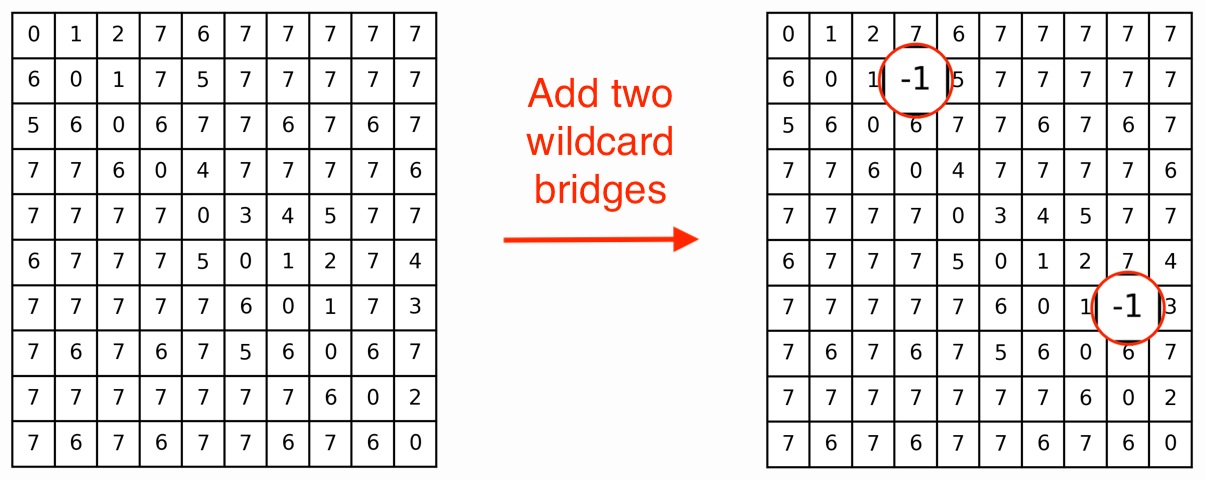
* Run LKH optimization and let it find a new optimal tour with these new constraints: the new tour is very likely to include these transitions, which can later be optimized with a wildcard by substituting 1a2bcde12bcdea with 182bcdea for an improvement of 6 characters.

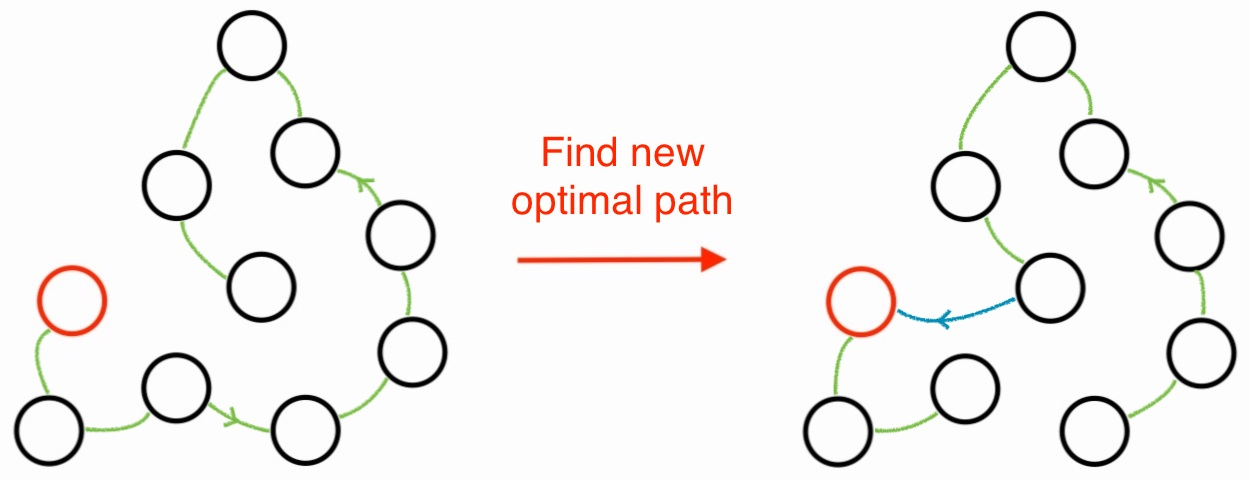

Repeating the process many many times and keeping track of the best result for each of the three strings separately, we can create a weakly decreasing sequence of lengths and collect the work done in many trials at the end.

In [ ]:
def perm_dist(p, q):
    i = p.index(q[0])
    return i if p[i:] == q[:7-i] else 7

def perms_to_string(perms):
    perms = list(perms)
    s = [*perms[0]]
    for p, q in zip(perms, perms[1:]):
        d = perm_dist(p, q)
        s.extend(q[-d:])
    return s

def distances_matrix(perms, first, second):
    m = np.zeros((len(perms), len(perms)), dtype='int8')
    for i, p in enumerate(perms):
        for j, q in enumerate(perms):
            m[i, j] = perm_dist(p, q)
    # store indices of all permutations of the form 1a2bcde
    candidates = []
    for i, p in enumerate(perms):
        if p[0] == 1 and p[2] == 2:
            candidates.append(i)
    # sample two of them according to input parameters
    sample = [candidates[first], candidates[second]] 
    for ind in sample:
        # retrieve index of the permutation 12bcdea
        tmp = perms[ind][:1] + perms[ind][2:] + perms[ind][1:2]
        ind2 = perms.index(tmp)
        # set distance from 1a2bcde to 12bcdea to -1 
        m[ind, ind2] = -1
        # save corresponding strings in cache to later do wildcard postprocessing
        cache.append([''.join(map(str, perms[ind])), ''.join(map(str, perms[ind2]))])
    return m

def write_params_file():
    with open('santa.par', 'w') as f:
        print('PROBLEM_FILE = santa.atsp', file=f)
        print('TOUR_FILE = best_tour.txt', file=f)
        print('INITIAL_TOUR_FILE = initial_tour.txt', file=f)
        print(f'INITIAL_TOUR_FRACTION = {FRACTION}', file=f)
        print('PATCHING_C = 5', file=f)
        print('PATCHING_A = 4', file=f)
        print('GAIN23 = YES', file=f)
        print('SEED = 42', file=f)
        print('MAX_TRIALS = 100000', file=f)
        print('TIME_LIMIT = 60', file=f) #seconds
        print('TRACE_LEVEL = 1', file=f)

def write_problem_file(distances):
    with open('santa.atsp', 'w') as f:
        print('TYPE: ATSP', file=f)
        print(f'DIMENSION: {len(distances) + 1}', file=f)
        print('EDGE_WEIGHT_TYPE: EXPLICIT', file=f)
        print('EDGE_WEIGHT_FORMAT: FULL_MATRIX\n', file=f)
        print('EDGE_WEIGHT_SECTION', file=f)
        for row in distances:
            print(' '.join(str(_) for _ in row), 42, file=f) # weights row, distance to depot
        print(' '.join(itertools.repeat('42', len(distances) + 1)), file=f) # distances from the depot
        print('DEPOT_SECTION', file=f)
        print(len(distances) + 1, file=f)
        print(-1, file=f)
        
def write_initial_tour_file(perms):
    with open('initial_tour.txt', 'w') as f:
        print('TOUR_SECTION', file=f)
        # add depot node for each string
        print(len(perms) + 1, ' '.join(str(_) for _ in range(1, len(perms)+1)), -1, file=f)

def read_output_tour(perms):
    perms = list(perms)
    with open('best_tour.txt') as f:
        lines = f.readlines()
    tour = lines[lines.index('TOUR_SECTION\n')+1:-2]
    return [perms[int(_) - 1] for _ in tour[1:]] 
    
def solve_atsp(perms, first, second, verbose=False):
    write_params_file()
    distances = distances_matrix(perms, first, second)
    write_problem_file(distances)
    write_initial_tour_file(perms)
    
    # Run LKH-3 to solve ATSP instance
    if verbose:
        !./LKH santa.par
    else:
        !touch lkh.log
        !./LKH santa.par >> lkh.log
    tour = read_output_tour(perms)
    return perms_to_string(tour)

In [ ]:
# how many permutations of type 1a2bcde are there in each string?
tot = []
for perms in strings_perms:
    count = 0
    for i, p in enumerate(perms):
        if p[0] == 1 and p[2] == 2:
            count += 1
    tot.append(count)
print(f'There are {tot} permutations of type 1a2bcde in strings, {sum(tot)} in total.')

In [ ]:
RUNS = 150
FRACTION = 0.85
best_lens = [2500, 2500, 2500]
best_runs = [0, 0, 0]
best_strings = strings
history = []
cache = []
visited = set()

for run in range(RUNS):
    valid = False
    while not valid:
        first, second = random.choice(list(itertools.combinations(range(min(tot)), 2)))
        # do not try a pair already tried!
        if (first, second) not in visited:
            visited.add((first, second))
            valid = True
    new_strings = [solve_atsp(_, first, second) for _ in strings_perms]
    new_lens = [len(_) for _ in new_strings]
    history.append(new_lens)
    # check if at least one string has improved and if so update best callbacks
    improved = False
    for i in range(3):
        if new_lens[i] < best_lens[i]:
            print(f'Improved length of the string {i} from {best_lens[i]} to {new_lens[i]}.')
            best_lens[i] = new_lens[i]
            best_runs[i] = run
            best_strings[i] = new_strings[i]
            improved = True
    if improved:
        print(f'Run {run} improved strings lengths to {best_lens}.')
        print('='*91)
    
print(f'best_lens {best_lens}')
print(f'best_runs {best_runs}')

We can appreciate the power of randomization in these plots: look at the variance of the results for each string, when we reached the minimum for the first time, and how many times we reached it again. Collecting rare results in the left tail of the distribution is what makes this approach useful and effective. The only downside? It seems like 2442 for all strings is the minimum under these conditions: after thousands of trials and brute-forcing all possible 780 combinations, I have never managed to go below this bound even with a single string.

In [ ]:
plt.style.use('ggplot')
history = np.array(history)
fig, axes = plt.subplots(2, 3, figsize=(20, 8))
axes = axes.flatten()
fig.suptitle(f'Randomization with {RUNS} Runs', fontsize=18)
for i in range(3):
    sns.histplot(history[:,i], ax=axes[i])
    sns.lineplot(data=history[:,i], ax=axes[i+3])
    axes[i].set_title(f'String {i}')
    axes[i].set_xlabel('Length')
    axes[i+3].set_xlabel('Run')
    axes[i+3].set_ylabel('Length')

Now we restructured the optimal path in such a way we can get a significant improvement from wildcard postprocessing. 
Let's check we haven't lost any permutations along the way to the current strings.

In [ ]:
strings = best_strings

all_perms = set(itertools.permutations(range(1, 8), 7))
mandatory_perms = set((1, 2) +  _ for _ in itertools.permutations(range(3, 8), 5))

strings_perms = [set(_) for _ in find_strings_perms(strings)]
for i, s in enumerate(strings_perms):
    if mandatory_perms - s:
        print(f'String #{i} is missing {mandatory_perms - s}.')
if all_perms - set.union(*strings_perms):
    print(f'Strings are missing {all_perms - set.union(*strings_perms)}.')

As everything is ok, now we'll save the found solution and improve it using wildcards.

In [ ]:
sub = pd.DataFrame()
sub['schedule'] = [''.join(LETTERS[x] for x in s) for s in strings]
sub_name = f'submission_no_wildcards_{"_".join(str(len(_)) for _ in strings)}.csv'
sub.to_csv(sub_name, index=False)

# Wildcards Optimization

Here we just get the substrings to substitute from execution logs, insert wildcards, and enjoy!
If something goes wrong, don't worry: the results for a single string are still valid if you run the notebook without changing the permutation rebalancing method, so you can save the strings that did well and merge them later with those from another notebook run!

In [ ]:
strings = [''.join(str(x) for x in s) for s in strings]

for i, string in enumerate(strings):
    perm1, perm2 = cache[6 * best_runs[i] + 2*i]
    perm3 = perm1[:1] + '8' + perm2[1:]
    print(f'String {i+1}: substituting {perm1 + perm2} with {perm3}')
    string = string.replace(perm1 + perm2, perm1[:1] + '8' + perm2[1:])
    
    perm1, perm2 = cache[6 * best_runs[i] + 2*i + 1]
    perm3 = perm1[:1] + '8' + perm2[1:]
    print(f'String {i+1}: substituting {perm1 + perm2} with {perm3}\n')
    string = string.replace(perm1 + perm2, perm1[:1] + '8' + perm2[1:])
    
    strings[i] = string

new_lens = list(map(len, strings))
if new_lens != [l - 12 for l in best_lens]:
    print('Warning: some substrings were not found!')
print(f'Improved strings lengths from {best_lens} to {new_lens}.')

We've used wildcards somewhat effectively, let's save this solution.

In [ ]:
sub = pd.DataFrame()
sub['schedule'] = [''.join(LETTERS[int(x)] for x in s) for s in strings]
sub_name = f'submission_with_wildcards_{"_".join(str(len(_)) for _ in strings)}.csv'
sub.to_csv(sub_name, index=False)

# Final Thoughts

The way to obtain a score of 2428 could be to run a procedure similar to this one but on all three strings at the same time using [MinMax CTSP](https://www.kaggle.com/kostyaatarik/minmax-ctsp). Unfortunately, I haven't been able to do this until now, but I still had a lot of fun using this randomized approach.
I can't wait to hear how others have managed to place wildcards even more effectively and their creative ideas! That's all, thank you for reading and see you next time!